# Make empirical IV surface

In this notebook we construct implied volatility surfaces from empirical data.

In [1]:
# Standard library imports
import numpy as np
import pandas as pd
import os
import logging
from os.path import dirname as up

# Important paths
code_dir = up(os.getcwd())
deep_cal_dir = up(up(os.getcwd()))

# Problem-specific libraries
from sklearn.linear_model import LinearRegression
from py_vollib.black_scholes.implied_volatility import implied_volatility
from py_lets_be_rational.exceptions import BelowIntrinsicException

# Logging stuff
logger = logging.getLogger("iv_surface_construction")
logger.setLevel(logging.INFO)
fh = logging.FileHandler(code_dir + "/logs/iv_surface.log")    
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fh.setFormatter(formatter)
logger.addHandler(fh)

# Plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

def set_style():

    sns.set_context("paper")

    sns.set(font='serif')
    
    sns.set_style("white", {
        "font.family": "serif",
        "font.serif": ["Times", "Palatino", "serif"]
    })
    
set_style()
%matplotlib inline

Read in preprocessed SPX data from disk and then use put-call-parity to get market interest rates. For each given maturity, look at all put and call prices and then run a regression to get a rate. 

In [2]:
df = pd.read_csv(deep_cal_dir + '/data/raw_data/processed_spx_calls_all_liquids.csv')
df2 = pd.read_csv(deep_cal_dir + '/data/raw_data/processed_spx_puts_all_liquids.csv')

In [3]:
# Remove illiquid options with zero open interest
df = df[df['Open Int'] != 0]
df2 = df2[df2['Open Int'] != 0]

# Remove options with zero Bid or Ask because distorts Mid price
df = df[(df.Bid !=0) & (df.Ask !=0)]
df2 = df2[(df2.Bid !=0) & (df2.Ask !=0)]

# For exploiting put-call-parity always need matching options
idx = df.index.intersection(df2.index)
df = df.loc[idx]
df2 = df2.loc[idx]

In [4]:
# Checking if dfs behave like expected:
assert((df.strike == df2.strike).all())
assert(((df.log_moneyness == df2.log_moneyness).all()))
assert((df['time to maturity (years)'] == df2['time to maturity (years)']).all())

unique_times = df['time to maturity (years)'].unique()

# Extracting empirical interest rates from put-call-parity by linear regression
# among all options of a given maturity.
for T in unique_times:
    
    logger.info('Examining time to maturity: {}.'.format(T))
     
    relevant_call_df = df[df['time to maturity (years)'] == T]
    relevant_put_df = df2[df2['time to maturity (years)'] == T]
    
    logger.debug('Call df: {}. Put df: {}.'.format(relevant_call_df, relevant_put_df))
    
    lr = LinearRegression(fit_intercept=True, n_jobs=-1)
    lr.fit(relevant_call_df.strike.values.reshape(-1,1), relevant_call_df.Mid - relevant_put_df.Mid)
    slope = lr.coef_[0]

    r = -1/T*np.log(-slope)
    
    logger.info('Sklearn slope: {}. Computed interest rate: {}.'.format(slope,r))
    
    df.loc[df['time to maturity (years)'] == T, 'rate'] = r

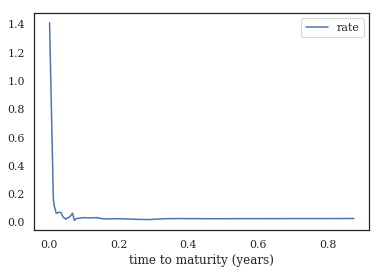

In [5]:
df.plot(x='time to maturity (years)', y = 'rate')

Rates differ immensely across maturities. So fix to most common rate.

In [6]:
df.rate = 0.024

Compute implied volatility from SPX market prices.

In [7]:
# spot price
S = 2731.25

In [8]:
# Wrapper around implied volatility to catch exceptions and set to NaN
def iv(price, spot, strike, maturity, rate):

    try:

        return implied_volatility(price, spot, strike, maturity, rate, 'c')

    except BelowIntrinsicException:

        return np.nan
    
iv = np.vectorize (iv)

In [9]:
df['iv'] = iv(df['Mid'], S, df.strike, df['time to maturity (years)'], df.rate)

Prepare plotting data and plot

In [10]:
# Remove all rows with NaN IV
df.dropna(inplace=True)

# Cutting off parts of the plane
log_moneyness_min = -0.1
log_moneyness_max = 0.2
smallest_time = df['time to maturity (years)'].unique()[1:].min()

plot_df = df[((df['log_moneyness']<log_moneyness_max) & 
              (df['log_moneyness']>log_moneyness_min) & 
              (df['time to maturity (years)']>= smallest_time)
             )]

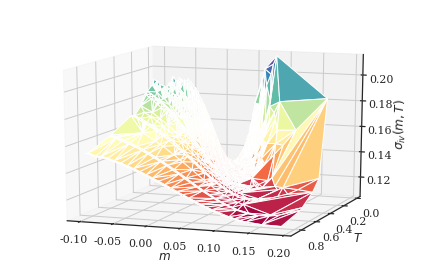

In [14]:
def plot_iv_surface(log_moneyness, maturity, iv, azim, elev, name, show=False, save=True):
    
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    
    ax.azim = azim
    ax.elev = elev
    
    ax.set_xlabel('$m$')
    ax.set_ylabel('$T$')
    ax.set_zlabel('$\sigma_{iv}(m, T)$')

#     ax.yaxis.set_ticks(np.linspace(0, 0.2, 4, endpoint=False))
#     ax.xaxis.set_ticks(np.linspace(-0.1, 0.28, 8, endpoint=True))
    ax.invert_xaxis()

    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))
    
    ax.plot_trisurf(log_moneyness, 
                    maturity, 
                    iv, antialiased=True, cmap = plt.cm.Spectral)

    plt.tight_layout()
    if save:
        fig.savefig(name)

    if not show:
        plt.close()

plot_iv_surface(plot_df['log_moneyness'], plot_df['time to maturity (years)'], plot_df.iv, 110, 13, 'test.png', show=True, save=False)

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


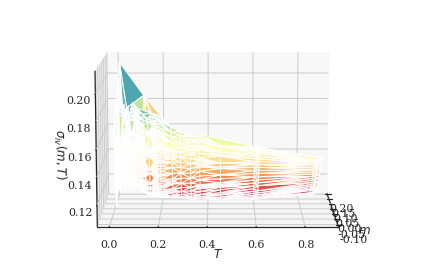

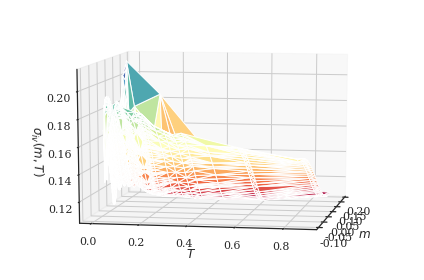

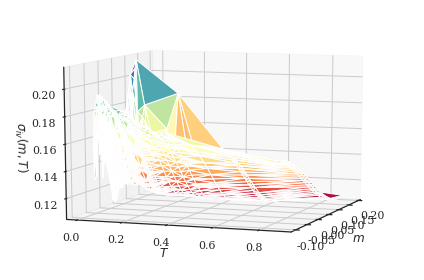

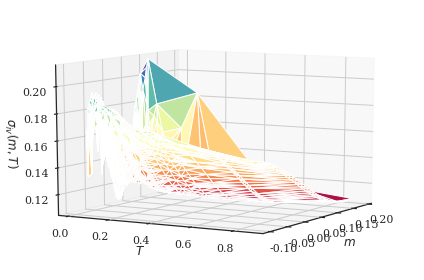

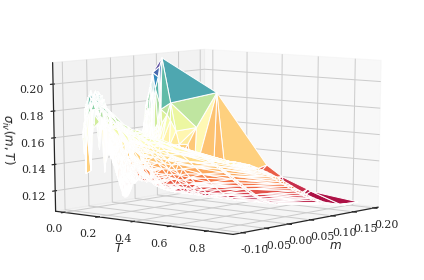

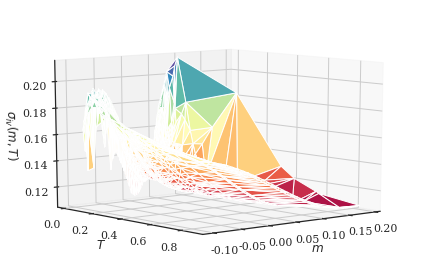

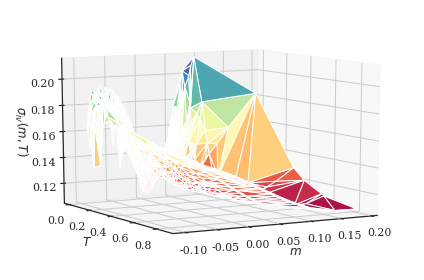

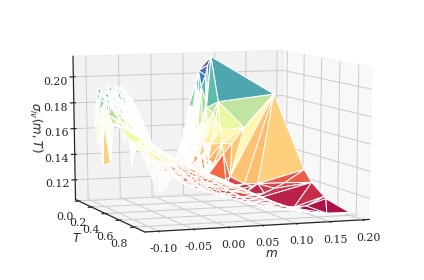

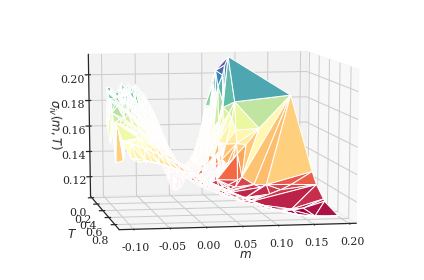

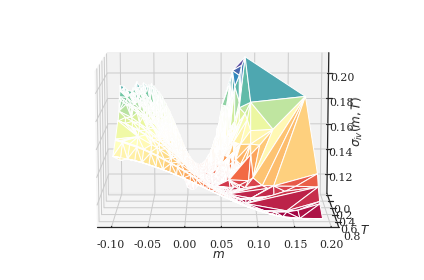

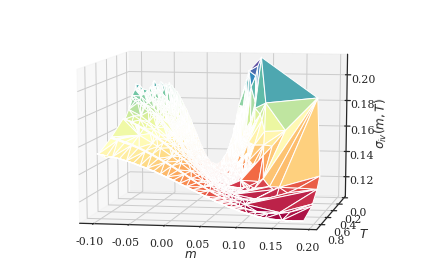

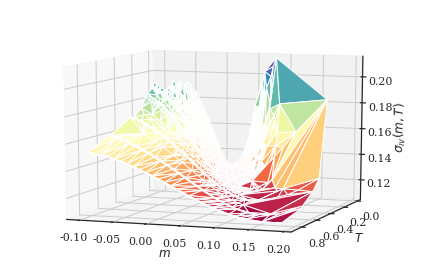

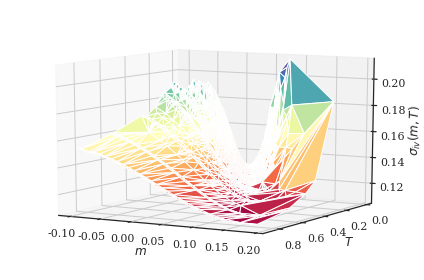

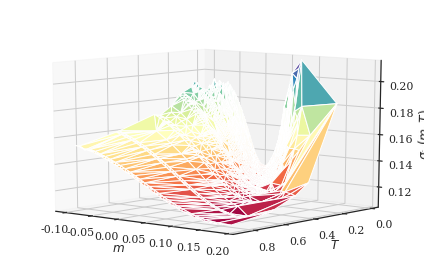

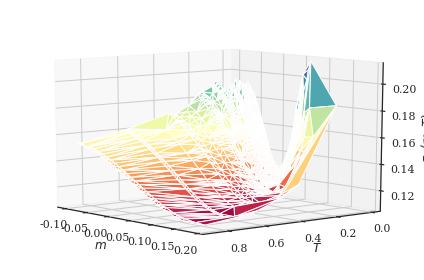

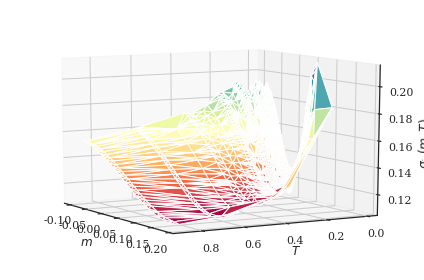

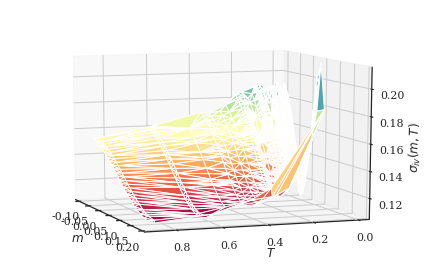

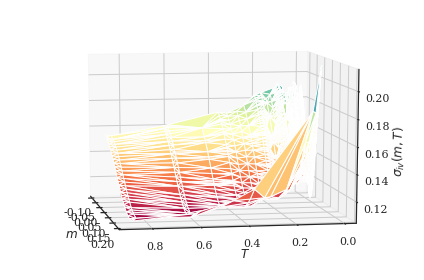

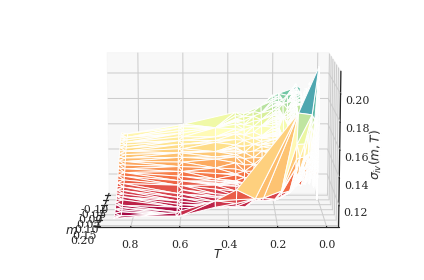

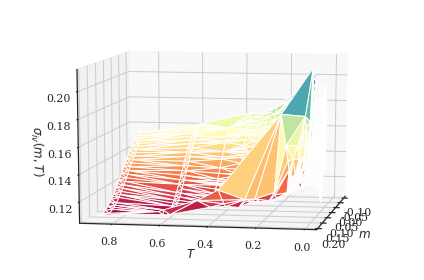

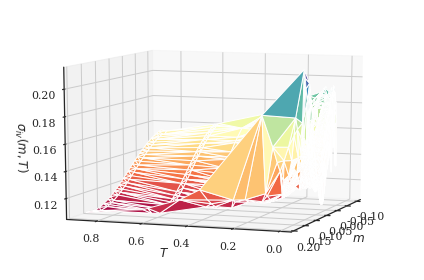

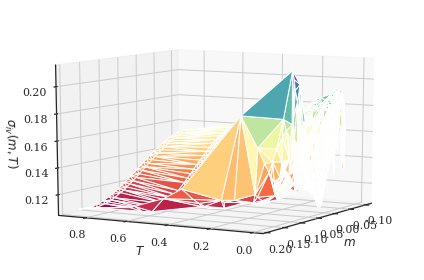

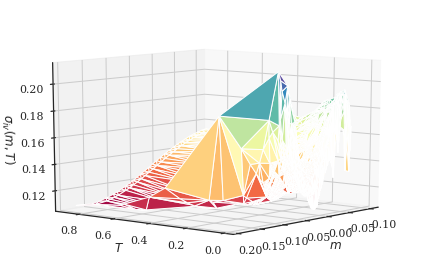

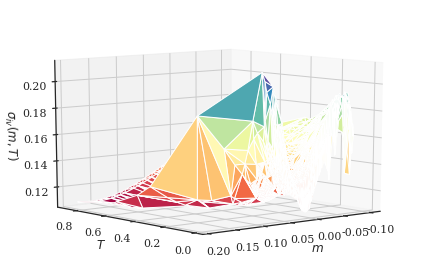

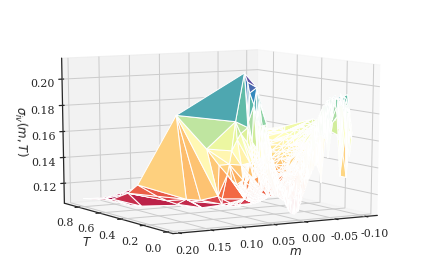

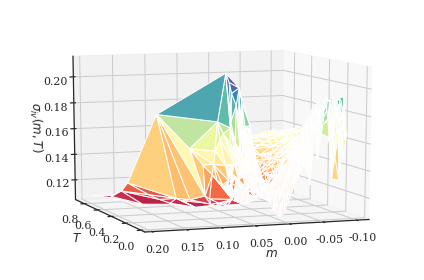

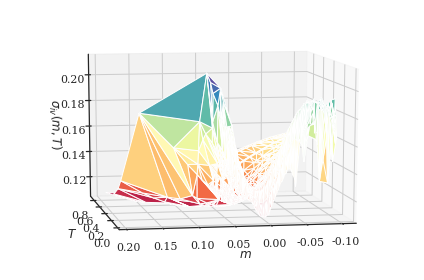

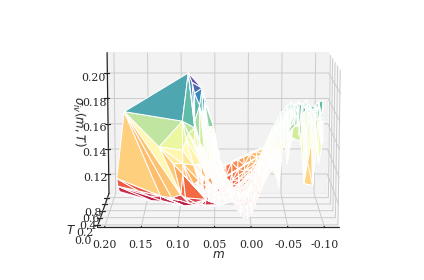

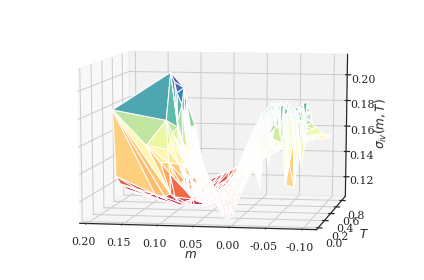

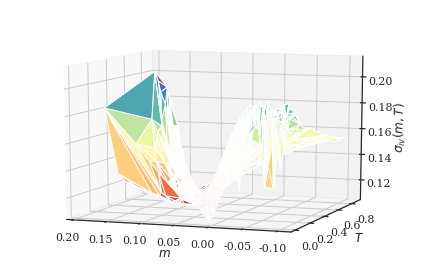

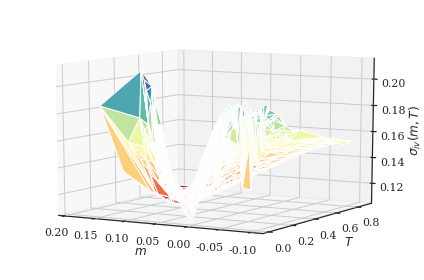

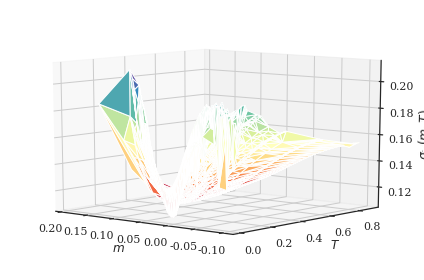

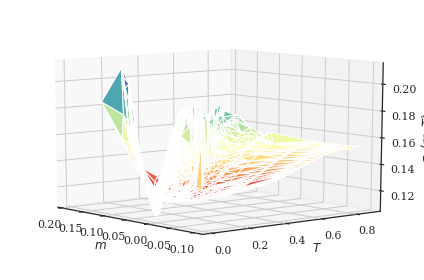

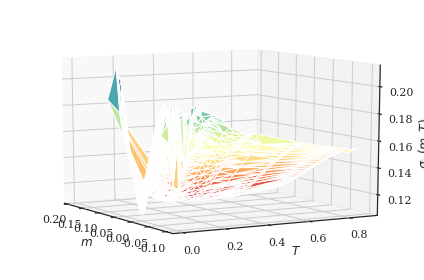

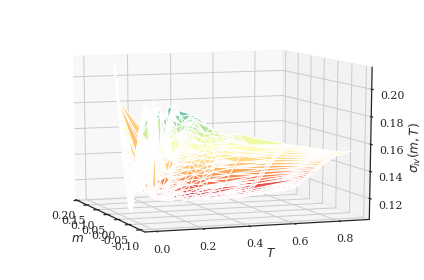

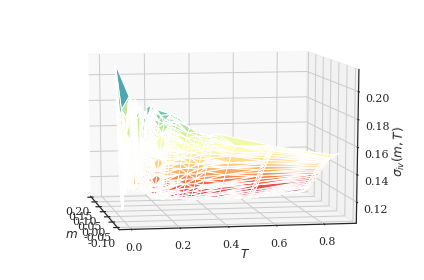

In [17]:
for angle in range(0, 360, 10):
    plot_iv_surface(plot_df['log_moneyness'], plot_df['time to maturity (years)'], plot_df.iv, angle, 10, 'test_{}.pdf'.format(angle), show=True, save=False)